What this code does
1. Runs all TSM code for the Sun
1. Adds noise to the data
1. Bins it
1. Then finds an equation for the background
1. Then finds the gaussian on that background
1. Locates V_max

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as c
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
from scipy.signal import peak_widths
from scipy.optimize import curve_fit
import math
from statistics import stdev 

## Bin_it
This function bins one array and reduces another array to match its length so they can be plotted together. This is done to reduce the noise whihc comes from the noise on the data.
###  Inputs
- yvalues: y array, the Power normally called Fulldata in this code
- xvalues: x array, the frequency
- binsize: the size of the bin the y values will be averaged in, every binsizeth value will also be taken from the x array<br>
### Outputs
- Binned y array (Power)
- reduced x array (Frequency)

In [14]:
def bin_it(yvalues,xvalues,binsize):
    '''puts an array into averaged bins of a given size'''
    N=int(math.ceil(len(yvalues)/binsize))
    C=0
    newy=[]
    while C<N:
        if (C+1)*binsize<len(yvalues):
            Q=(np.sum(yvalues[C*binsize:(C+1)*binsize]))/binsize
        else:
            Q=(np.sum(yvalues[C*binsize:len(yvalues)]))/binsize
        newy.append(Q)
        C+=1
    return np.array(newy),xvalues[0::binsize] 

## addnoise
adds noise to and array. The method used to generate the noise was taken from a recommended scientific paper
### Input
- pure: orignal array
### output
- array with noise added

In [3]:
#Adds random noise
def addnoise(pure):
    vary = np.random.uniform(0, 1, pure.shape)
    signal = -(pure* np.log(vary))
    return signal

## gausgran
Is the equation of a gaussian where the base is not just a flat line, it is adjusted by an array fitted to the background called fittedgran.
### Inputs
- x: array over which the gaussian with background should be plotted
- height: Height of the gaussian
- centre: Centre of the gaussian
- width: Width of the gaussain at half its height
### Output
- An equation with gives a gaussian on a line fitted to the background of the data

In [4]:
def gausgran(x,height,centre,width):
    '''plots a gaussian acounting for granulation'''
    return height*np.exp((-(x-centre)**2)/(2*width**2))+fittedgran

## gausgran1
Very similar to gausgran except the fittedgran is reduced so a plot can be done around the envelope. The cropping is hard coded so not applicable to all stars
### Inputs
- x: array over which the gaussian with background should be plotted
- height: Height of the gaussian
- centre: Centre of the gaussian
- width: Width of the gaussain at half its height
### Output
- An equation with gives a cropped gaussian on a line fitted to the background of the data

In [5]:
def gausgran1(x,height,centre,width):
    '''plots a gaussian acounting for granulation'''
    return height*np.exp((-(x-centre)**2)/(2*width**2))+fittedgran[quater:3*quater]

## count
Find the number of values in an array between two given values
### Inputs
- list1: array to be analysed
- l: lower limit of count
-

In [6]:
def count(list1, l, r): 
    # x for x in list1 is same as traversal in the list 
    # the if condition checks for the number of numbers in the range  
    # l to r  
    # the return is stored in a list 
    # whose length is the answer 
    return len(list(x for x in list1 if l <= x <= r)) 

In [7]:
def findgran(x,y):
    #guess_vals=[np.max(y),y[round(len(y)/4)]]
    guess_vals=[5.84171514e+00, -1.99778025e-04]
    best_vals, covar =curve_fit(graneq, x, y,p0=guess_vals)
    return best_vals

In [8]:
def graneq(x,A,tau):
    '''equation to describe the background'''
    return A/(1+(2*np.pi*x*tau)**4)

In [9]:
def find_vmax(Fulldata,N,binsize, shot_noise_level):
    frequency=np.linspace(1,6000,6000)
    x = np.array(frequency)
    vmag = np.full((len(frequency)), shot_noise_level) #where 8 defines the apparent magnitude
    shot_noise = 18*10**(-0.4*(11.0-vmag))
    C=0
    fails=0
    centres=[]
    widths=[]
    amps=[]
    while C<N:
        y=addnoise(Fulldata+shot_noise) #adds noise to y values, inside loop so each curve fit will be different due to the random noise
        yb,xb=bin_it(y,x,binsize) #yb and xb as in xbinned and ybinned bins data with a binsize of 50
        best_vals=findgran(xb,yb)
        fittedgran=graneq(xb,best_vals[0],best_vals[1])
        #guess_vals=[np.max(yb),xb[0]+(xb[-1]-xb[0])/2,(xb[-1]-xb[0])/4] #rough guesses which will change with each plot
        guess_vals=[1,3100,300]
        #try and except are used in case a gaussian cant be fitted to the data. try and execpt allow the code to continue even if a
        #fit can not be found. If a fit can be found the v_max is recorded and added to an array of v_max values. If a fit can not
        #be found the failure is recored and the code continues with the next trial
        try: 
            best_vals, covar =curve_fit(gausgran, xb, yb,p0=guess_vals)
            #attempts to fit a gaussian to the data taking acount of the granulation
            centres.append(best_vals[1])
            amps.append(best_vals[0])
            widths.append(best_vals[2])
        except:
            fails+=1 #records failure
            C+=1
            continue
        C+=1
    percentage=fails*100/N
    print(f'Number of trials {N}')
    #print(f'binsize: {binsize}')
    #print(f'shot noise level {shot_noise_level}')
    print(f'{percentage}% trails failed to fit a gaussian') 
    if len(centres)<1: #prevents error in code
        print('Code failed to fit any gaussians ')
    else:   
        average_centres=np.mean(centres)
        difference=np.abs(average_centres-3100)
        print(f'average v_max {average_centres} which is {difference} away from the true value of 3100 ')
        print('')
        return np.mean(centres)

In [10]:
#Using the Gaussian as the height in the function to plot the Lorentzians
def lorentz_gauss(modes, Gauss, width):
    Lorentzh = np.zeros(len(x))
    for p in range(len(modes)):
        Lorentzh+=(Gauss*((1+((x - np.array(modes)[p])/(width/2))**2)**(-1)))
    Lorentzh_array = np.array(Lorentzh)
    return Lorentzh_array

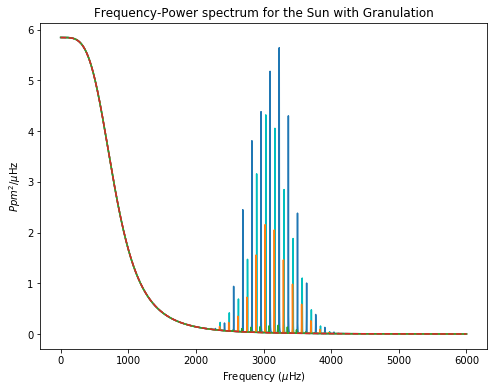

In [11]:
#define parameters
delta_v_sun = 134.8 #microHz
D = 1.5
n=np.linspace(1,40,40)
l= 0
l1 = 1
l2 = 2
l3 = 3
width = 10

frequency=np.linspace(1,6000,6000)
x = np.array(frequency)
H=5
epsilon=1.5
V_max_sun = 3100 #microHz
A_max_sun = 2.1 #ppm from Warrick's paper


#calculate modes for different angular degree, l and radial mode, n
modes=[]
for i in range(len(n)):
    modes.append(delta_v_sun*(n[i]+((l)/2)+epsilon)-D*(l)*((l)+1))

modes1=[]
for i in range(len(n)):
    modes1.append(delta_v_sun*(n[i]+((l1)/2)+epsilon)-D*(l1)*((l1)+1))
    
modes2=[]
for i in range(len(n)):
    modes2.append(delta_v_sun*(n[i]+((l2)/2)+epsilon)-D*(l2)*((l2)+1))

modes3=[]
for i in range(len(n)):
    modes3.append(delta_v_sun*(n[i]+((l3)/2)+epsilon)-D*(l3)*((l3)+1))

#Defines Gaussian curve with height A squared
sigma = 2.123*delta_v_sun#microHz
Gauss = (A_max_sun**2)*(np.exp(-0.5*((x-V_max_sun)/sigma)**2))


#Defines parameters for granulation
tau_sun = 200 #seconds
g_sun = 274 #metres per second squared
T_eff_sun = 5777 #Kelvin
sigma_sun = 50000/(c.R_sun.value/(1000*10**3)) #ppm

granulation = (4*np.sqrt(2)*tau_sun/1e6*(sigma_sun)**2)/(1+(2*np.pi*x*tau_sun/1e6)**4) #ppm squared per micro hertz
#Defines width of the Lorentzians
alpha = -25.5+29.1 #for the Sun
gamma_alpha = 6.3 - 1.8 #for the Sun
linewidth = (alpha*np.log(x/V_max_sun)+np.log(gamma_alpha))


#Heights of modes scaled to their relative visibilities 
Lorentzh_array_0 = lorentz_gauss(modes, Gauss, linewidth)
Lorentzh_array_1 = lorentz_gauss(modes1, Gauss*1.5, linewidth)
Lorentzh_array_2 = lorentz_gauss(modes2, Gauss*0.5, linewidth)
Lorentzh_array_3 = lorentz_gauss(modes3, Gauss*0.04, linewidth)

#Plots the Lorentzians with the granulation as a full spectrum
plt.figure(figsize=(8,6))
plt.plot(x, Lorentzh_array_0+granulation, 'c')
plt.plot(x, Lorentzh_array_1+granulation)
plt.plot(x, Lorentzh_array_2+granulation)
plt.plot(x, Lorentzh_array_3+granulation)
plt.title('Frequency-Power spectrum for the Sun with Granulation')
plt.xlabel('Frequency ($\mu$Hz)')
plt.ylabel('$Ppm^2$/$\mu$Hz')

#Fulldata is the modes and the granulation without noise as this needs to be added in each loop
Fulldata=Lorentzh_array_0+Lorentzh_array_1+Lorentzh_array_2+Lorentzh_array_3+granulation
vmag = np.full((len(frequency)), -27) #here 8 defines the apparent magnitude
shot_noise = 18*10**(-0.4*(11.0-vmag))
best=findgran(frequency,Fulldata+shot_noise)
plt.plot(frequency,graneq(frequency,best[0],best[1]),'--')
plt.show()
Fulldata=shot_noise+Fulldata

Code is 25.0% complete
Code is 50.0% complete
Code is 75.0% complete
Code is 100.0% complete
No fails: 0
0.0% trails failed to fit a gaussian

average v_max 3093.742823440443 which is 6.257176559557138 away from the true value of 3100 


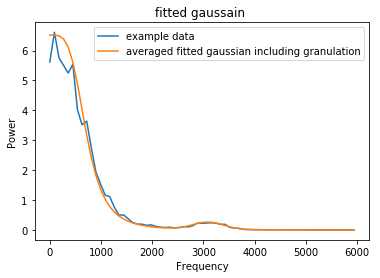

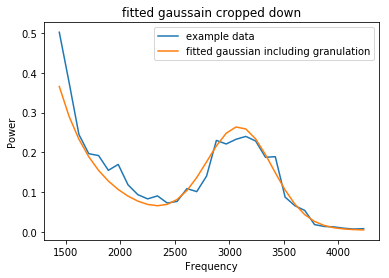

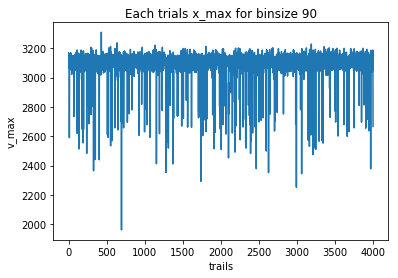

151/4000 are outside the expected range


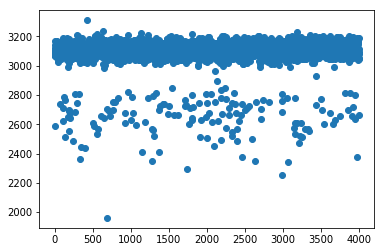

In [12]:
frequency=np.linspace(1,6000,6000)
x = np.array(frequency)
binsize=90
C=0
Q=0
fails=0
centres=[]
widths=[]
amps=[]
N=4000 #number of trials to find v_max with differnt noise, 4000
while C<N:
    y=addnoise(Fulldata) #adds noise to y values, inside loop so each curve fit will be different due to the random noise
    yb,xb=bin_it(y,x,binsize) #yb and xb as in xbinned and ybinned bins data with a binsize of 50
    best_vals=findgran(xb,yb)
    fittedgran=graneq(xb,best_vals[0],best_vals[1])
    guess_vals=[np.max(yb),xb[0]+(xb[-1]-xb[0])/2,(xb[-1]-xb[0])/4] #rough guesses which will change with each plot
    #try and except are used in case a gaussian cant be fitted to the data. try and execpt allow the code to continue even if a
    #fit can not be found. If a fit can be found the v_max is recorded and added to an array of v_max values. If a fit can not
    #be found the failure is recored and the code continues with the next trial
    try: 
        best_vals, covar =curve_fit(gausgran, xb, yb,p0=guess_vals)
        #attempts to fit a gaussian to the data taking acount of the granulation
        '''section bellow can be used to look at indivudal results'''
        #if best_vals[1]<2400:
        #    if Q<2:
        #        plt.plot(xb,gausgran(xb,best_vals[0],best_vals[1],best_vals[2]))
        #        plt.plot(xb,yb)
        #        plt.axvline(best_vals[1],color='red')
        #        plt.show()
        #        Q+=1
    except:
        fails+=1 #records failure
        C+=1
        continue
    centres.append(best_vals[1])
    amps.append(best_vals[0])
    widths.append(best_vals[2])
    C+=1
    if C % (25*(N/100)) == 0:
        print(f'Code is {C/(N/100)}% complete') #if statment that allows tracking of code completion while it is running
percentage=fails*100/N
print(f'No fails: {fails}')
print(f'{percentage}% trails failed to fit a gaussian') 
if len(centres)<1: #prevents error is code
    print('Code failed to fit any gaussians ')
    print(fails)
else:   
    average_centres=np.mean(centres)
    difference=np.abs(average_centres-3100)
    print('')
    print(f'average v_max {average_centres} which is {difference} away from the true value of 3100 ')
    x_vals=bin_it(addnoise(Fulldata),x,binsize)[1]
    y_vals=bin_it(addnoise(Fulldata),x,binsize)[0]
    plt.plot(x_vals,y_vals, label='example data')
    plt.plot(x_vals,gausgran(x_vals,np.mean(amps),np.mean(centres),np.mean(widths)), 
             label='averaged fitted gaussian including granulation')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.title('fitted gaussain ')
    plt.legend()
    plt.show()
    quater=int(len(x_vals)/4)
    plt.plot(x_vals[quater:3*quater],y_vals[quater:3*quater], label='example data')
    plt.plot(x_vals[quater:3*quater],gausgran1(x_vals[quater:3*quater],np.mean(amps),np.mean(centres),np.mean(widths)),
            label='fitted gaussian including granulation')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.title('fitted gaussain cropped down')
    plt.legend()
    plt.show()
xs=np.linspace(1,N,N-fails)
plt.plot(xs,centres)
plt.xlabel('trails')
plt.ylabel('v_max')
plt.title(f'Each trials x_max for binsize {binsize}')
plt.show()
plt.scatter(xs,centres)
values_outside_expected_range=count(centres, 1000, 2900)
No_vals=len(centres)
print(f'{values_outside_expected_range}/{No_vals} are outside the expected range')

Number of trials 4000
0.0% trails failed to fit a gaussian
average v_max 3106.7631251464645 which is 6.7631251464645175 away from the true value of 3100 

Number of trials 4000
0.0% trails failed to fit a gaussian
average v_max 3106.552034529899 which is 6.552034529899174 away from the true value of 3100 

Number of trials 4000
0.0% trails failed to fit a gaussian
average v_max 3107.1234811790873 which is 7.123481179087321 away from the true value of 3100 

Number of trials 4000
0.025% trails failed to fit a gaussian
average v_max 3105.9213186057827 which is 5.921318605782744 away from the true value of 3100 

Number of trials 4000
0.0% trails failed to fit a gaussian
average v_max 3107.415725989143 which is 7.415725989143084 away from the true value of 3100 

Number of trials 4000
0.025% trails failed to fit a gaussian
average v_max 3106.8940180164045 which is 6.894018016404516 away from the true value of 3100 

Number of trials 4000
0.0% trails failed to fit a gaussian
average v_max 

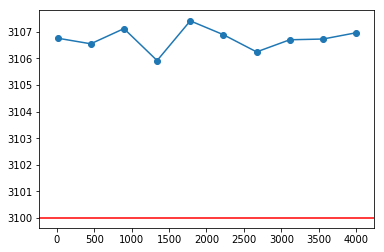

In [13]:
#loop of 4000 seems to be a good amount, its large enough to get a good value, but small enough to not run for a long time
#binsize of 90 seems to best
granulation = (4*np.sqrt(2)*tau_sun/1e6*(sigma_sun)**2)/(1+(2*np.pi*x*tau_sun/1e6)**4) #ppm squared per micro hertz
Fulldata=Lorentzh_array_0+Lorentzh_array_1+Lorentzh_array_2+Lorentzh_array_3+granulation
v_maxs=[]
error=[]
Ns=np.linspace(10,4000,10)
#binsizes=np.linspace(50,150,3)
for n in Ns:
    v_maxs.append(find_vmax(Fulldata,4000,90,-27))#data,No loops, binsize, 
v_maxs=np.array(v_maxs)
plt.plot(Ns,v_maxs)
plt.scatter(Ns,v_maxs)
plt.axhline(3100,color='r')
plt.show()
#shot_noise_levels=[1,2,3,4,5,6]
#for n in shot_noise_levels:
#    Q=find_vmax(4000,90,n)
#    v_maxs.append(np.mean(Q))
#    error.append(stdev(Q))
#plt.plot(shot_noise_levels,v_maxs)
#plt.scatter(shot_noise_levels,v_maxs)
#plt.axhline(3100,color='r')
#plt.xlabel('shot_noise_levels')
#plt.ylabel('v_max')
#plt.show()
#plt.plot(shot_noise_levels, error)
#plt.xlabel('shot_noise_levels')
#plt.ylabel('standard deviation of values')
#plt.show()
#print(error)